## xcube Data Store Framework – Climate Data Store
### Creating and writing data cubes

This notebook demonstrates how to access [Climate Data Store](https://cds.climate.copernicus.eu) (CDS) data via the dedicated xcube store, which provides dynamic data cube views into each gridded data set. Furthermore, an overview will be given on how to write data cubes into a team storage.

Please, also refer to the [DeepESDL documentation](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

Brockmann Consult, 2024

-----------------

**This notebook runs with the python environment `deepesdl-xcube-1.7.0`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**

**Please note:** 
    
To access data from the Climate Data Store, you need a CDS API key. 

#### Obtain a CDS Personal Access Token

You can obtain a CDS Personal Access Token as follows:

1. Create a user account on the
   [CDS Website](https://cds-beta.climate.copernicus.eu/).
2. Log in to the website with your username and password.
3. Navigate to your [user page](https://cds-beta.climate.copernicus.eu/profile), 
   where you can find your Personal Access Token.

#### Configure CDS API access

Your CDS Personal Access Token must be made available to the CDS API library.
You can do this by creating a file named `.cdsapirc` in your home directory,
with the following format:

```
url: https://cds-beta.climate.copernicus.eu/api
key: <PERSONAL-ACCESS-TOKEN>
```

Replace `<PERSONAL-ACCESS-TOKEN>` with your Personal Access Token.

Then export the `CDSAPI_URL` and `CDSAPI_KEY` environment variables:

```bash
export CDSAPI_URL=https://cds-beta.climate.copernicus.eu/api
export CDSAPI_KEY=[PERSONAL-ACCESS-TOKEN]
```

#### Agree to the terms of use for the datasets you require

The datasets available through CDS have associated terms of use. Before
accessing a dataset via the API, you must agree to its terms of use, which
can only be done via the CDS website, as follows:

1. [Log in](https://cds-beta.climate.copernicus.eu) to the CDS website,
   and go to 'Datasets' to find the dataset you require.
2. On the dataset's web page, select the ‘Download’ tab.
3. Scroll to the bottom of the page, and you will see a section titled
   ‘Terms of use’, which will contain either an ‘Accept terms’ button to
   allow you to accept the terms, or a confirmation that you have already
   accepted the terms.

Once you have accepted the terms on the website, the dataset will also be
made available to you through the API.

In [30]:
import os
os.environ['CDSAPI_URL'] = 'https://cds-beta.climate.copernicus.eu/api'
os.environ['CDSAPI_KEY'] = '[PERSONAL-ACCESS-TOKEN]'

In [2]:
# mandatory imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

# Utilities for notebook visualization
import shapely.geometry
import IPython.display
from IPython.display import JSON
import matplotlib as mpl
import matplotlib.pyplot as plt

Configure matplotlib to display graphs inline directly in the notebook and set a sensible default figure size.

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16,12

### Connect to cds store

Check whether the `cds` store is among the available stores, if not please follow the installation information from the top of this notebook. 

In [4]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

Usually we need more information to get the actual data store object. Which data store parameters are available for `cds`?

In [5]:
get_data_store_params_schema('cds')

Provide mandatory parameters to instantiate the store class:

In [6]:
store = new_data_store('cds')
store

Which datasets are provided? (the list may contain both gridded and vector datasets):

In [7]:
JSON(store.list_data_ids())

<IPython.core.display.JSON object>

Get more info about a specific dataset. This includes a description of the possible open formats:

### Retrieve and open requested dataset

There are 4 required parameters, so we need to provide them to open a dataset:

In [8]:
store.describe_data('reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis')

### Let's set a bbox

In [9]:
bbox=[-5, 45, 35, 65]

In [10]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

### Now set the other parameters for opening the dataset from the store: 

In [11]:
dataset = store.open_data('reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis', 
                          variable_names=['2m_temperature'], 
                          bbox=bbox, 
                          spatial_res=0.25, 
                          time_range=['2006-01-01', '2010-12-31'])
dataset

xcube-cds version 0.9.3
2024-09-18 07:54:59,234 INFO Request ID is bbe8cdca-f852-4881-84eb-561efb844200
2024-09-18 07:54:59,284 INFO status has been updated to accepted
2024-09-18 07:55:00,844 INFO status has been updated to running
2024-09-18 07:55:03,157 INFO status has been updated to successful


fb560841cf5bceb6b69d7064c2268332.nc:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

<xarray.Dataset> Size: 3MB
Dimensions:  (lat: 80, lon: 160, time: 60)
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 640B 64.88 64.62 64.38 64.12 ... 45.62 45.38 45.12
  * lon      (lon) float64 1kB -4.875 -4.625 -4.375 -4.125 ... 34.38 34.62 34.88
    expver   (time) <U4 960B ...
  * time     (time) datetime64[ns] 480B 2006-01-01 2006-02-01 ... 2010-12-01
Data variables:
    t2m      (time, lat, lon) float32 3MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-18T07:22 GRIB to CDM+CF via cfgrib-0.9.1...

We can explore this dataset by plotting a temperature map for selected time points. First, we select January 2001. Land areas – and mountain ranges in particular – show up on the map as colder regions.

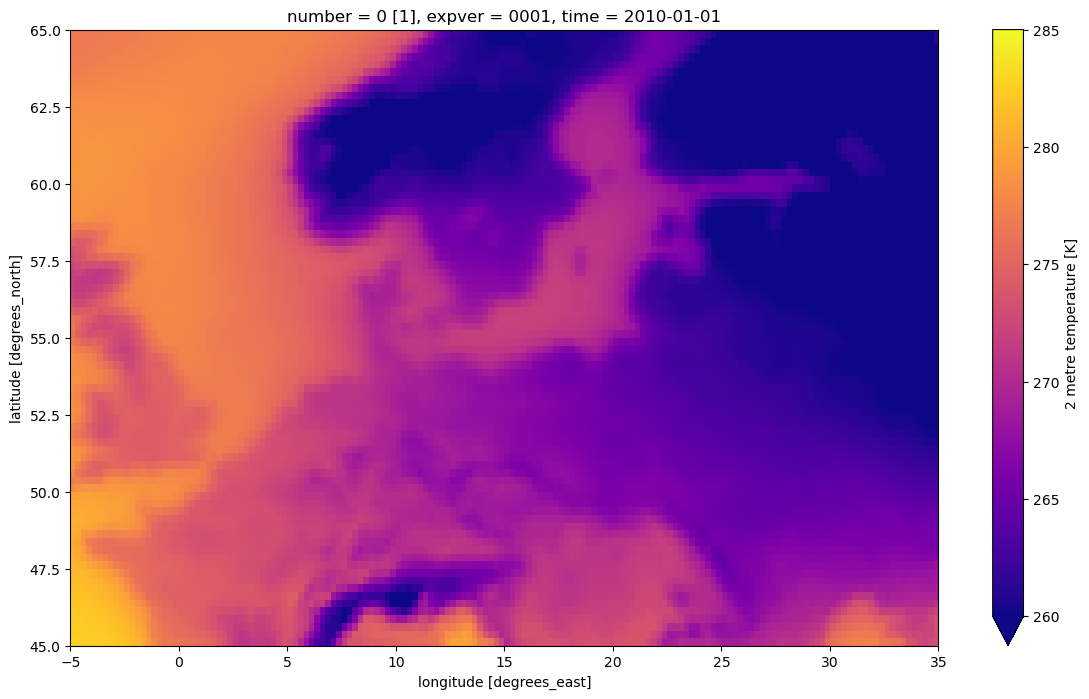

In [12]:
t2m_2001_jan = dataset.t2m.sel(time='2010-01-01 00:00:00', method='nearest')
t2m_2001_jan.plot.imshow(vmin=260, vmax=285, figsize=(14, 8), cmap='plasma')

### Write cube in team storage

To store the cube in your teams user space, please first retrieve the details from your environment variables as the following:

In [13]:
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

You need to instantiate a s3 datastore pointing to the team bucket:

In [14]:
from xcube.core.store import new_data_store
team_store = new_data_store("s3", 
                       root=S3_USER_STORAGE_BUCKET, 
                       storage_options=dict(anon=False, 
                                            key=S3_USER_STORAGE_KEY, 
                                            secret=S3_USER_STORAGE_SECRET))

If you have stored no data to your user space, the returned list will be empty:

In [15]:
list(team_store.get_data_ids())

['SST.levels',
 'amazonas_v8.zarr',
 'amazonas_v9.zarr',
 'analysed_sst.zarr',
 'noise_trajectory.zarr',
 'reanalysis-era5-single-levels-monthly-means-subset-2001-2010_TMH.zarr']

In [16]:
team_store.write_data(dataset,'reanalysis-era5-single-levels-monthly-means-subset-2006-2010_TMH.zarr', replace=True)

'reanalysis-era5-single-levels-monthly-means-subset-2006-2010_TMH.zarr'

In [17]:
list(team_store.get_data_ids())

['SST.levels',
 'amazonas_v8.zarr',
 'amazonas_v9.zarr',
 'analysed_sst.zarr',
 'noise_trajectory.zarr',
 'reanalysis-era5-single-levels-monthly-means-subset-2001-2010_TMH.zarr',
 'reanalysis-era5-single-levels-monthly-means-subset-2006-2010_TMH.zarr']

### Open data from team storage

In [18]:
cds_subset = team_store.open_data('reanalysis-era5-single-levels-monthly-means-subset-2006-2010_TMH.zarr')
cds_subset

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 60, lat: 80, lon: 160)
Coordinates:
    expver   (time) <U4 960B dask.array<chunksize=(60,), meta=np.ndarray>
  * lat      (lat) float64 640B 64.88 64.62 64.38 64.12 ... 45.62 45.38 45.12
  * lon      (lon) float64 1kB -4.875 -4.625 -4.375 -4.125 ... 34.38 34.62 34.88
    number   int64 8B ...
  * time     (time) datetime64[ns] 480B 2006-01-01 2006-02-01 ... 2010-12-01
Data variables:
    t2m      (time, lat, lon) float32 3MB dask.array<chunksize=(30, 40, 80), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2024-09-18T07:22 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

### Visualize the dataset using xcube viewer

In [19]:
from xcube.webapi.viewer import Viewer

Let's set some attributes of the variable, so the colormapping does not fall back on the default

In [20]:
cds_subset.t2m.attrs["color_value_min"] = 270
cds_subset.t2m.attrs["color_value_max"] = 310
cds_subset.t2m.attrs["color_bar_name"] = "plasma"

In [21]:
cds_subset.attrs["title"] = "ERA5 2m Temperature"

In [ ]:
viewer = Viewer()

404 GET /viewer/config/config.json (127.0.0.1): xcube viewer has not been been configured
404 GET /viewer/config/config.json (127.0.0.1) 3.75ms
Uncaught exception GET /datasets?details=1 (127.0.0.1)
HTTPServerRequest(protocol='http', host='deep.earthsystemdatalab.net', method='GET', uri='/datasets?details=1', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/conda/deepesdl/36a2c06c01942b4828818c0c77b0355c0d66b085bd378ed58a97b1f2e589092a-20240918-063730-228122-584-xcube-1.7.0/lib/python3.11/site-packages/tornado/web.py", line 1790, in _execute
    result = await result
             ^^^^^^^^^^^^
  File "/home/conda/deepesdl/36a2c06c01942b4828818c0c77b0355c0d66b085bd378ed58a97b1f2e589092a-20240918-063730-228122-584-xcube-1.7.0/lib/python3.11/site-packages/xcube/server/webservers/tornado.py", line 335, in get
    await self._call_method("get", *args, **kwargs)
  File "/home/conda/deepesdl/36a2c06c01942b4828818c0c77b0355c0d66b085bd378ed58a97b1f2e589

In [23]:
viewer.add_dataset(cds_subset)

'a2f214fd-d771-4a78-908b-55f6cb9d4935'

You can click on the viewer link to open xcube Viewer in a new browser tab:

In [24]:
viewer.info()

Server: https://deep.earthsystemdatalab.net/user/alicebalfanz/proxy/8000
Viewer: https://deep.earthsystemdatalab.net/user/alicebalfanz/proxy/8000/viewer/?serverUrl=https://deep.earthsystemdatalab.net/user/alicebalfanz/proxy/8000


You can also open xcube Viewer inlined here:

In [25]:
viewer.show()

In [26]:
viewer.stop_server()

In case you wish to delete data:

In [28]:
team_store.delete_data('reanalysis-era5-single-levels-monthly-means-subset-2006-2010_TMH.zarr')